# Project Report


## Microsoft Malware Detection : Data preparation and EDA


### Summary


This projects aims to analyze and process the data provided by Microsoft for malware prediction. The project tackles high memory issues first and then moves onto cleaning and exploratory data analysis to prepare the data to fit Machine Learning/ Deep Learning models directly. Project also shares insights gained from the data about the main causes of the malware spread and which kind of devices are more likely to be affected.

### Project Flow

1. Data Acquisition:
   Obtain relevant data from Kaggle competition and download them into CSV files.

   __Data Source__:
   Original data set is huge and we won't be able to run the whole pipeline on GitHub, that's why a small subset of the data is used which contains     only first 100k Rows fromt the original dataset : https://www.kaggle.com/competitions/microsoft-malware-prediction/data

   Dataset comprises information about the __OS type__, __Antivirus__ information, __Platform__, __Touch or Non touch__ devices etc about the machines and the label in __HasDetections__ which is a binary value describing if a malware was detected on the machine or not.

2. After downloading the data, csv files are loaded and processed and finally stored in .sqlite and saved.
   Steps in preprocessing are:

   (i). Optimize memory usage by type casting to required dtypes like if the data can be stored in int8 and is using int16 currently then it would reduce memory usage by converting to int8.

   (ii) load_and_transform function from pipeline.py, If the proportion (rate) of the most frequently occurring value is greater than 90% (rate > 0.9), it removes that column from the good_cols list.

   (iii) This good cols list is also used for test data.

   (iv) convert_to_db function converts both train and test data to sqlite db and saves them with respective table names as 'train' and 'test'.

3. After this we test our pipeline with some tests to test the functionality of the above features, which can be run using test.sh file.

4. Finally we added a CI pipeline which runs all the tests everytime there's an update to the main branch to verify if everything is working or not.

Rest of this report follows data processing, exploration and visualization along with the insights gained from the data and discussing the limitations along with the conclusions in the end.

### Libraries

Import all necessary libraries like __Plotly__, __Seaborn__ for visualization and __Pandas__, __Numpy__ for processing.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import os
import time
import plotly
import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.tools as tls
pyo.init_notebook_mode()

import gc
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")

Setting max column and row range so that we can see all the columns in data.head()

In [2]:
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)

In [3]:
train = pd.read_csv(r"E:\FAU-SEM2\made-classwork\data\train_sub.csv")
test = pd.read_csv(r"E:\FAU-SEM2\made-classwork\data\test_sub.csv")

In [37]:
train.shape, test.shape

((100000, 83), (100000, 82))

In [38]:
train.head()

MachineIdentifier   ProductName EngineVersion  \
0  0000028988387b115f69f31a3bf04f09  win8defender   1.1.15100.1   
1  000007535c3f730efa9ea0b7ef1bd645  win8defender   1.1.14600.4   
2  000007905a28d863f6d0d597892cd692  win8defender   1.1.15100.1   
3  00000b11598a75ea8ba1beea8459149f  win8defender   1.1.15100.1   
4  000014a5f00daa18e76b81417eeb99fc  win8defender   1.1.15100.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1735.0       0            7.0000                 0   
1     4.13.17134.1    1.263.48.0       0            7.0000                 0   
2  4.18.1807.18075  1.273.1341.0       0            7.0000                 0   
3  4.18.1807.18075  1.273.1527.0       0            7.0000                 0   
4  4.18.1807.18075  1.273.1379.0       0            7.0000                 0   

   DefaultBrowsersIdentifier  AVProductStatesIdentifier  AVProductsInstalled  \
0                        NaN                53,447.0000               1.0000   
1                        NaN                53,447.0000               1.0000   
2                        NaN                53,447.0000               1.0000   
3                        NaN                53,447.0000               1.0000   
4                        NaN                53,447.0000               1.0000   

   AVProductsEnabled  HasTpm  CountryIdentifier  CityIdentifier  \
0             1.0000       1                 29    128,035.0000   
1             1.0000       1                 93      1,482.0000   
2             1.0000       1                 86    153,579.0000   
3             1.0000       1                 88     20,710.0000   
4             1.0000       1                 18     37,376.0000   

   OrganizationIdentifier  GeoNameIdentifier  LocaleEnglishNameIdentifier  \
0                 18.0000            35.0000                          171   
1                 18.0000           119.0000                           64   
2                 18.0000            64.0000                           49   
3                     NaN           117.0000                          115   
4                     NaN           277.0000                           75   

    Platform Processor     OsVer  OsBuild  OsSuite OsPlatformSubRelease  \
0  windows10       x64  10.0.0.0    17134      256                  rs4   
1  windows10       x64  10.0.0.0    17134      256                  rs4   
2  windows10       x64  10.0.0.0    17134      768                  rs4   
3  windows10       x64  10.0.0.0    17134      256                  rs4   
4  windows10       x64  10.0.0.0    17134      768                  rs4   

                                 OsBuildLab SkuEdition  IsProtected  \
0  17134.1.amd64fre.rs4_release.180410-1804        Pro       1.0000   
1  17134.1.amd64fre.rs4_release.180410-1804        Pro       1.0000   
2  17134.1.amd64fre.rs4_release.180410-1804       Home       1.0000   
3  17134.1.amd64fre.rs4_release.180410-1804        Pro       1.0000   
4  17134.1.amd64fre.rs4_release.180410-1804       Home       1.0000   

   AutoSampleOptIn PuaMode  SMode  IeVerIdentifier   SmartScreen  Firewall  \
0                0     NaN 0.0000         137.0000           NaN    1.0000   
1                0     NaN 0.0000         137.0000           NaN    1.0000   
2                0     NaN 0.0000         137.0000  RequireAdmin    1.0000   
3                0     NaN 0.0000         137.0000  ExistsNotSet    1.0000   
4                0     NaN 0.0000         137.0000  RequireAdmin    1.0000   

   UacLuaenable Census_MDC2FormFactor Census_DeviceFamily  \
0        1.0000               Desktop     Windows.Desktop   
1        1.0000              Notebook     Windows.Desktop   
2        1.0000               Desktop     Windows.Desktop   
3        1.0000               Desktop     Windows.Desktop   
4        1.0000              Notebook     Windows.Desktop   

   Census_OEMNameIdentifier  Census_OEMModelIdentifier  \
0              

In [4]:
stats = []
for col in train.columns:
    stats.append((col, train[col].nunique(), train[col].isnull().sum() * 100 / train.shape[0], train[col].value_counts(normalize=True, dropna=False).values[0] * 100, train[col].dtype))
    
stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage of missing values', 'Percentage of values in the biggest category', 'type'])
stats_df.sort_values('Percentage of missing values', ascending=False).head(10)

Feature  Unique_values  Percentage of missing values  \
28                     PuaMode              1                        99.969   
41       Census_ProcessorClass              3                        99.573   
8    DefaultBrowsersIdentifier            288                        95.110   
68  Census_IsFlightingInternal              1                        83.163   
52  Census_InternalBatteryType             22                        71.240   
71       Census_ThresholdOptIn              2                        63.738   
75     Census_IsWIMBootEnabled              1                        63.659   
31                 SmartScreen             11                        35.731   
15      OrganizationIdentifier             37                        30.664   
29                       SMode              2                         5.932   

    Percentage of values in the biggest category     type  
28                                        99.969   object  
41                                        99.573   object  
8                                         95.110  float64  
68                                        83.163  float64  
52                                        71.240   object  
71                                        63.738  float64  
75                                        63.659  float64  
31                                        48.288   object  
15                                        47.149  float64  
29                                        94.035  float64

### Column Observations:

1. **High Missing Values:**
   - Columns `PuaMode` and `Census_ProcessorClasare almost useless because almost all of the data is missing, so it would be better to drop themmns.
   
2. **Dominant Category:**
   - In the `DefaultBrowsersIdentifier` comore than 95% data belong to a single category, which means it is not usablecolumn.
   
3. **Potential Analysis:**
   - `Census_IsFlightingInternal` has an unusua and would need further deep divenificance.

4. **Imbalanced Columns:**
   - There are 26 columns where one category contains over 90% of the values. These imbalanced columns should be considered for removal from the dataset.

5. **Numeric vs. Categorical:**
   - Despite being considered numeric, columns like `CityIdentifier` might be more appropriately treated as categorical. A detailed exploration during EDA will confirm this.

6. **Categorical Columns:**
   - Except for `Census_SystemVolumeTotalCapacity`, all other column's performance.
p them.

In [5]:
droppable_features = []
droppable_features.append('PuaMode')
droppable_features.append('Census_ProcessorClass')

In [6]:
train['HasDetections'].value_counts()

HasDetections
0    50072
1    49928
Name: count, dtype: int64

Label is balanced which is very good for classification objective.

In [7]:
train['Census_IsTouchEnabled'].value_counts()

Census_IsTouchEnabled
0    87458
1    12542
Name: count, dtype: int64

Most devices are not touch enabled, which is expected as most devices using microsft are windows based and does not have touch functionality.

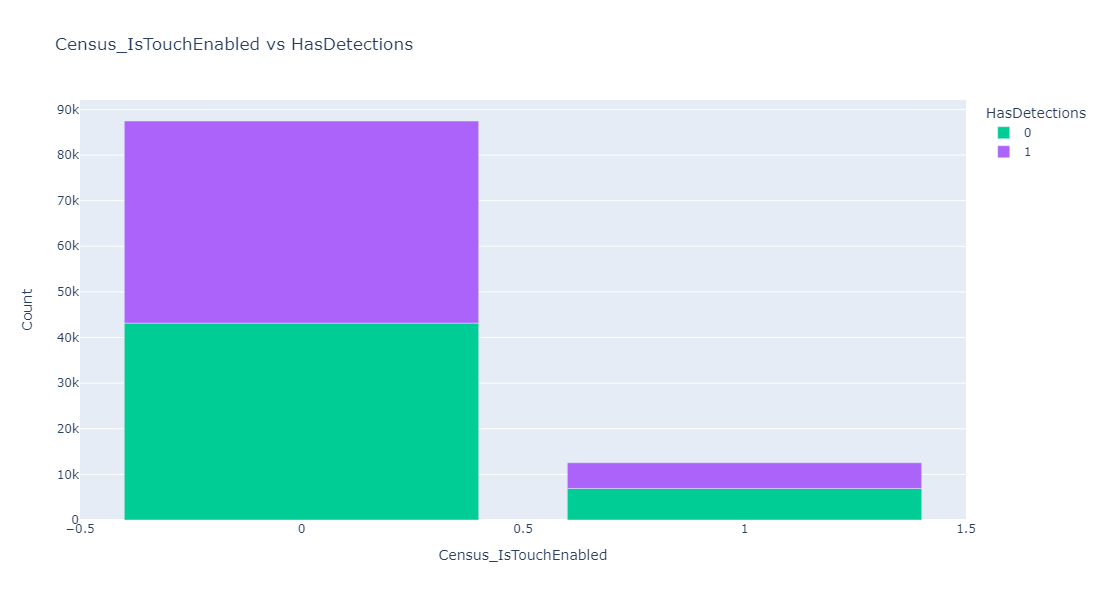

In [8]:
import plotly.express as px

def plot_categorical_vs_detection(df, column_name):
    column_counts = df[column_name].value_counts()
    detection_counts = df.groupby([column_name, 'HasDetections']).size().unstack(fill_value=0)
    data_for_plotly = detection_counts.reset_index()
    melted_data = pd.melt(data_for_plotly, id_vars=[column_name], var_name='HasDetections', value_name='Count')
    fig = px.bar(melted_data, x=column_name, y='Count', color='HasDetections',
                 labels={column_name: column_name, 'Count': 'Count'},
                 title=f'{column_name} vs HasDetections',
                 category_orders={'HasDetections': ['0', '1']},
                 color_discrete_map={'0': '#1f77b4', '1': '#ff7f0e'})
    fig.update_layout(width=800, height=600)
    fig.show()

plot_categorical_vs_detection(train, 'Census_IsTouchEnabled')

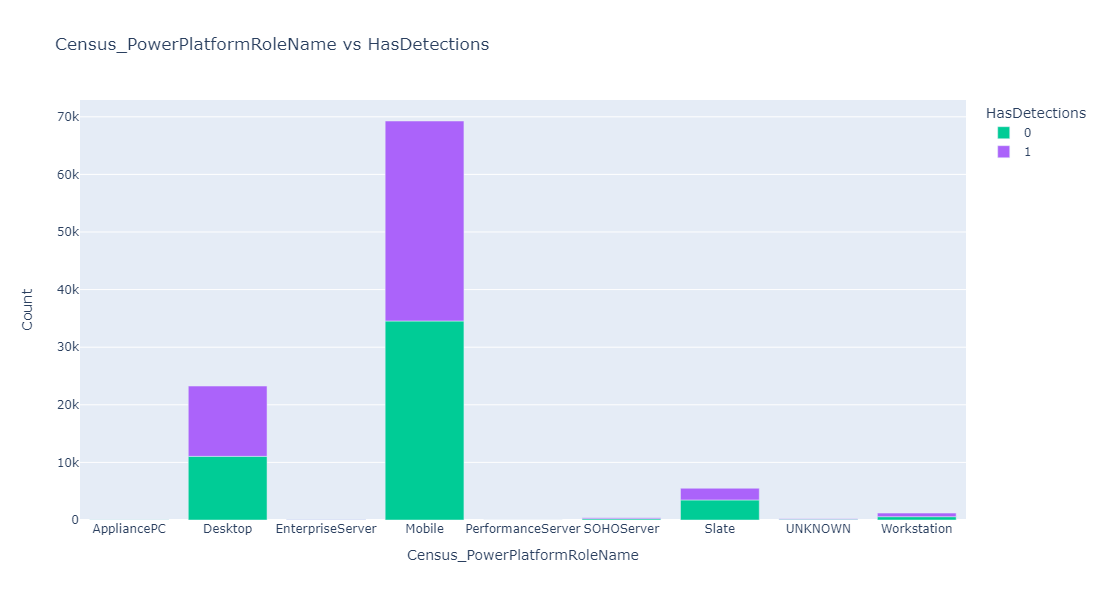

In [9]:
plot_categorical_vs_detection(train, 'Census_PowerPlatformRoleName')

As expected Mobile phones and Desktops are most targeted devices.

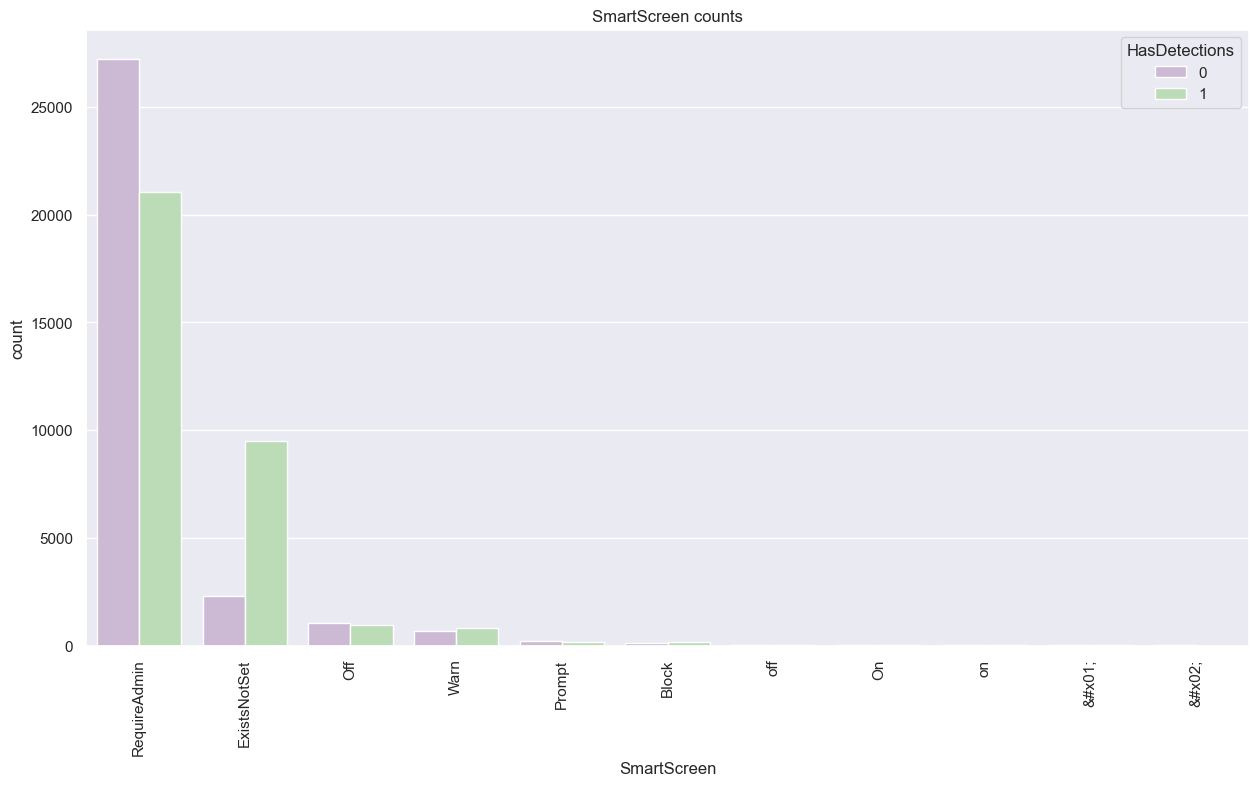

In [10]:
sns.set(rc={'figure.figsize':(15, 8)})
sns.countplot(x="SmartScreen", hue="HasDetections",  palette="PRGn", data=train)
plt.title("SmartScreen counts")
plt.xticks(rotation='vertical')
plt.show()

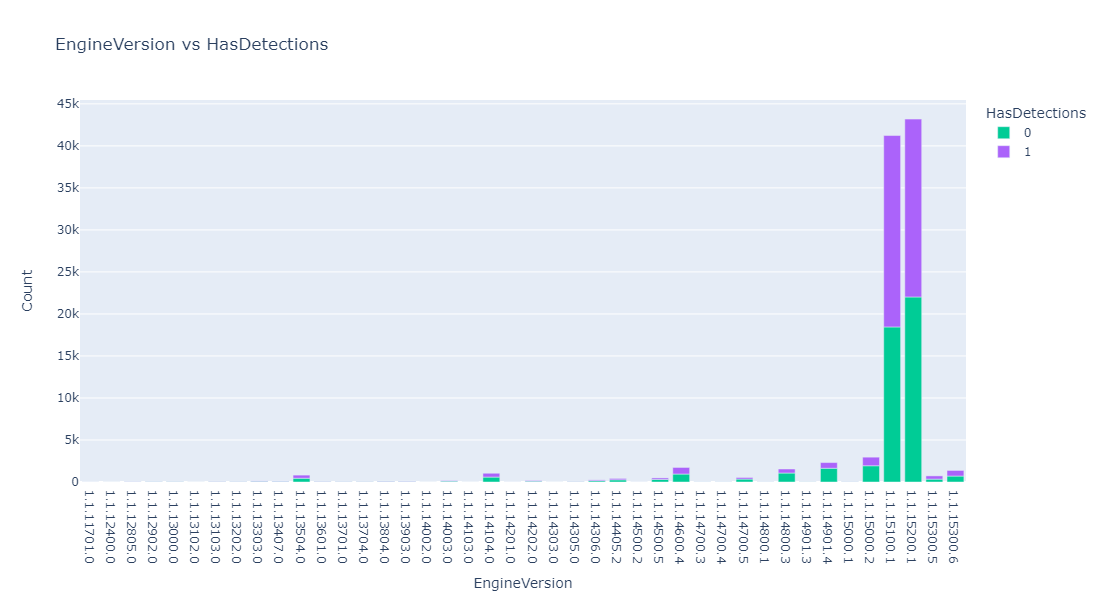

In [11]:
plot_categorical_vs_detection(train,'EngineVersion')

Two Engine variants are most popular, would be interesting to check them against touch or not touch devices.

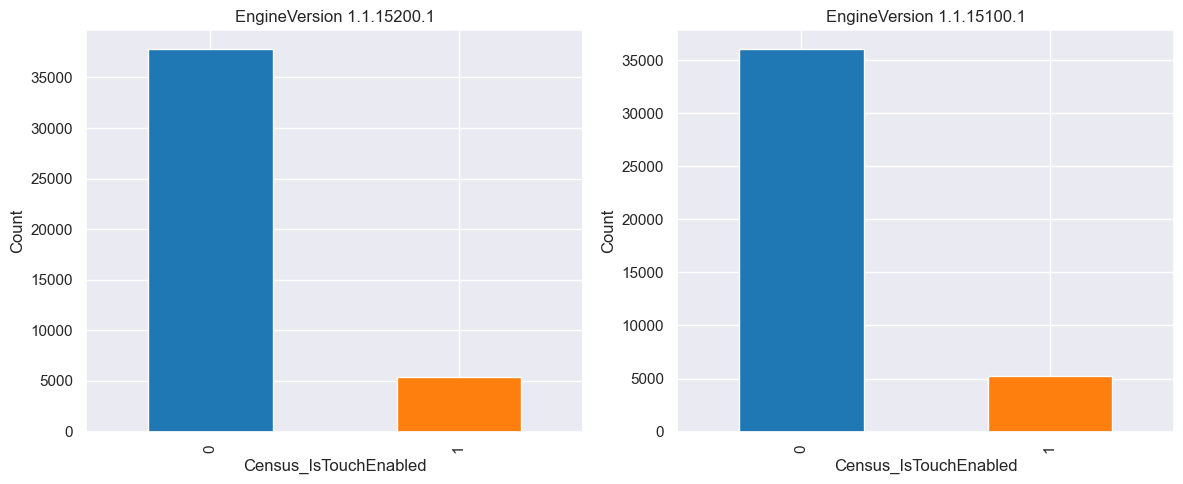

In [12]:
import matplotlib.pyplot as plt
top_engine_versions = ['1.1.15200.1', '1.1.15100.1']
fig, axes = plt.subplots(nrows=1, ncols=len(top_engine_versions), figsize=(12, 5))
for i, version in enumerate(top_engine_versions):
    subset_df = train[train['EngineVersion'] == version]
    subset_df['Census_IsTouchEnabled'].value_counts().plot(kind='bar', ax=axes[i], color=['#1f77b4', '#ff7f0e'])
    axes[i].set_title(f'EngineVersion {version}')
    axes[i].set_xlabel('Census_IsTouchEnabled')
    axes[i].set_ylabel('Count')

plt.tight_layout()
plt.show()

Both EngineVersion supports fewer number of touch devices.

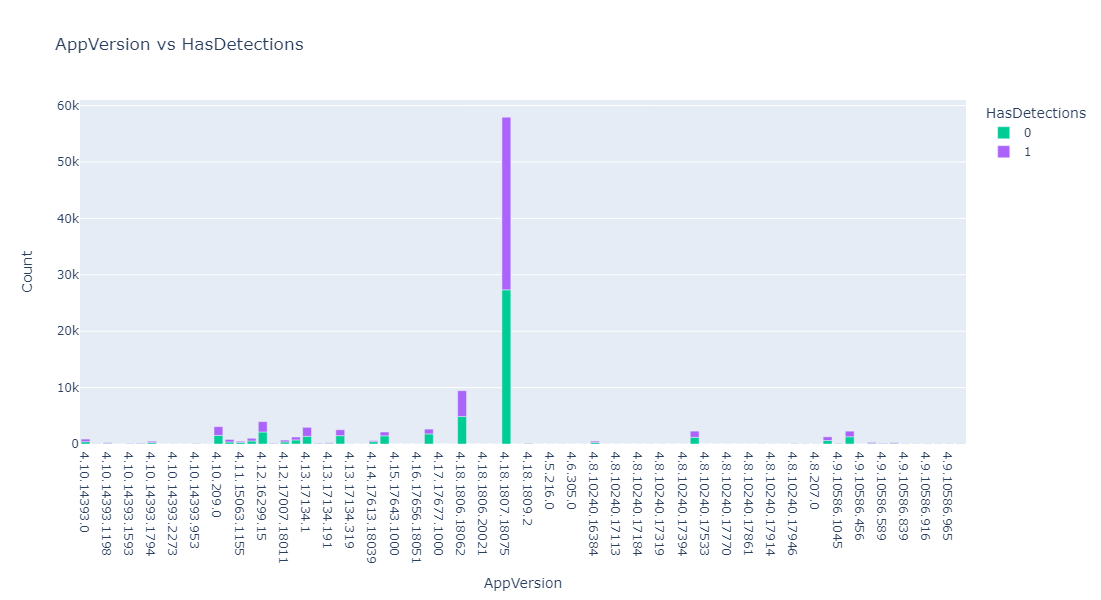

In [13]:
plot_categorical_vs_detection(train,'AppVersion')

In [14]:
#plot_categorical_vs_detection(train,'AvSigVersion')

AvSigVersion doesn't provide useful information

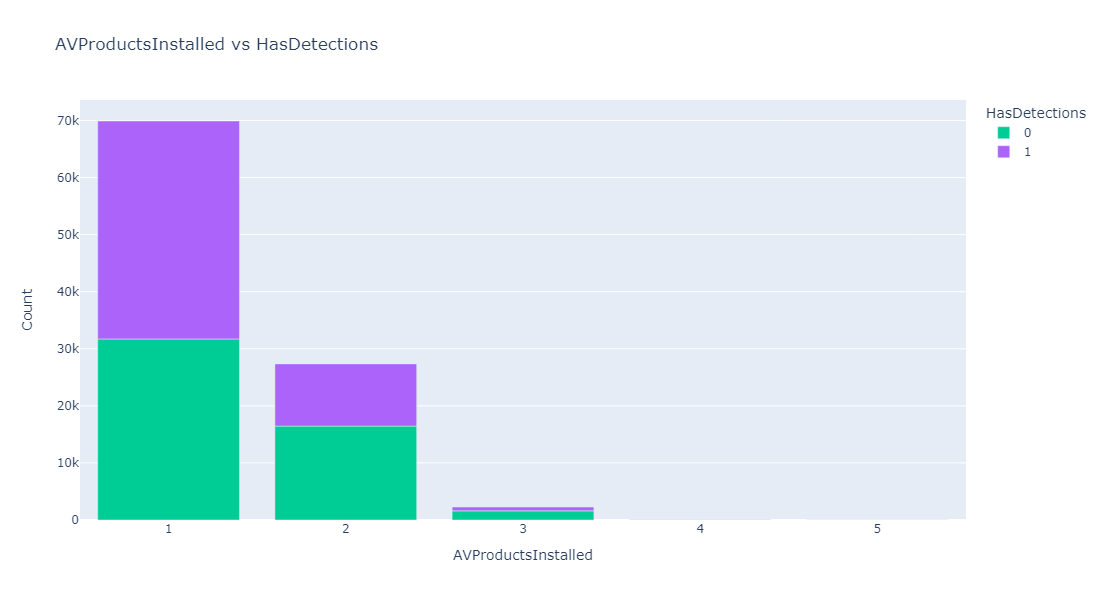

In [15]:
plot_categorical_vs_detection(train,'AVProductsInstalled')

Interesting thing here is that if a device has antivirus software even then they are more likely to be infected.

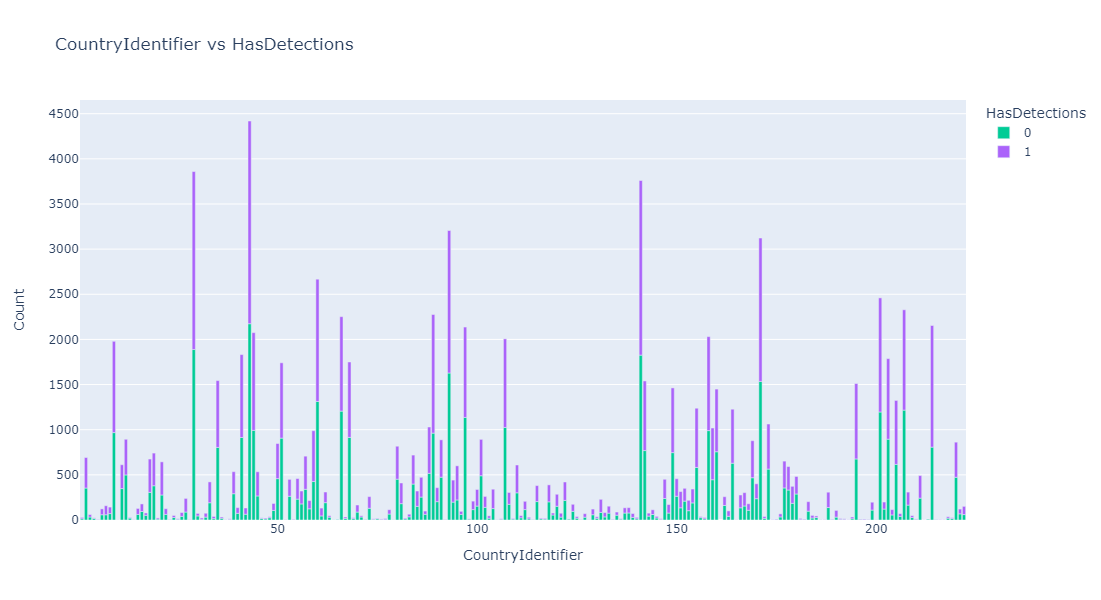

In [16]:
plot_categorical_vs_detection(train,'CountryIdentifier')

Most countries have around 50% infection rate. Would be interesting to plot top countries with infection.

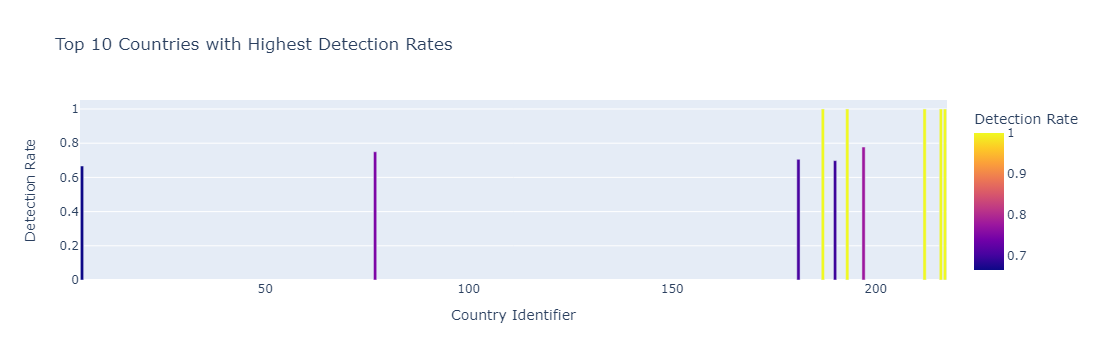

In [17]:
country_detection_rates = train.groupby('CountryIdentifier')['HasDetections'].mean().reset_index()
top_countries = country_detection_rates.nlargest(10, 'HasDetections')
fig = px.bar(top_countries, x='CountryIdentifier', y='HasDetections', color='HasDetections',
             labels={'CountryIdentifier': 'Country Identifier', 'HasDetections': 'Detection Rate'},
             title='Top 10 Countries with Highest Detection Rates',
             category_orders={'HasDetections': ['0', '1']},
             color_discrete_map={'0': '#1f77b4', '1': '#ff7f0e'})

fig.show()

Intersting, some countries have very high detection rates let's look at the cities.

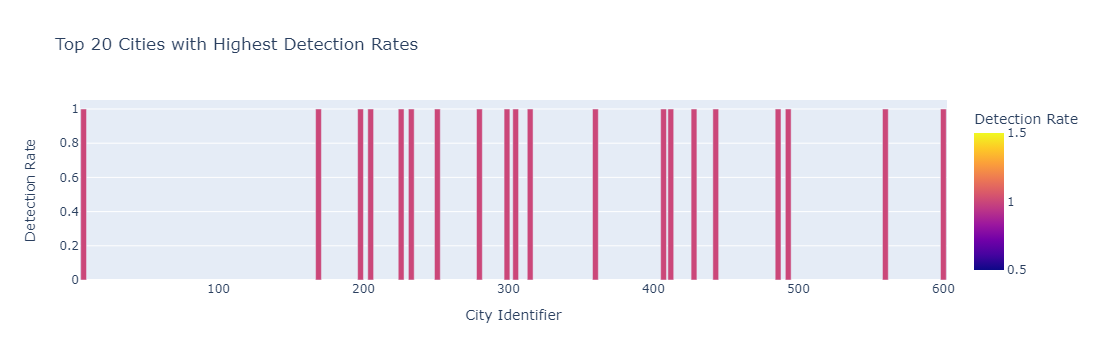

In [18]:
country_detection_rates = train.groupby('CityIdentifier')['HasDetections'].mean().reset_index()
top_countries = country_detection_rates.nlargest(20, 'HasDetections')
fig = px.bar(top_countries, x='CityIdentifier', y='HasDetections', color='HasDetections',
             labels={'CityIdentifier': 'City Identifier', 'HasDetections': 'Detection Rate'},
             title='Top 20 Cities with Highest Detection Rates',
             category_orders={'HasDetections': ['0', '1']},
             color_discrete_map={'0': '#1f77b4', '1': '#ff7f0e'})

fig.show()

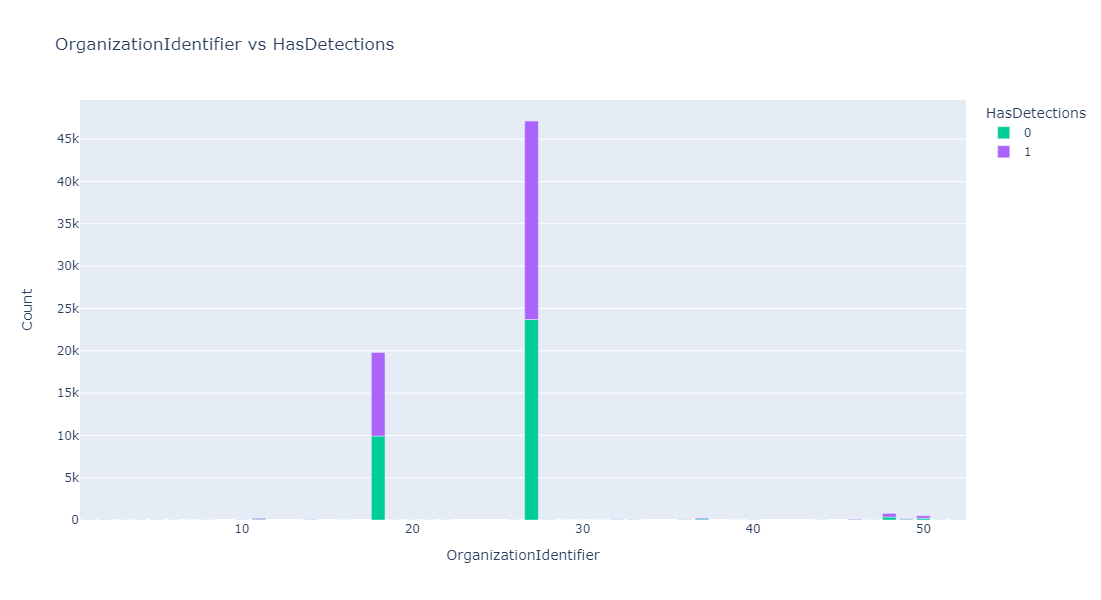

In [19]:
plot_categorical_vs_detection(train,'OrganizationIdentifier')

Two organizations cover most of the computers.

<Figure size 1000x600 with 0 Axes>

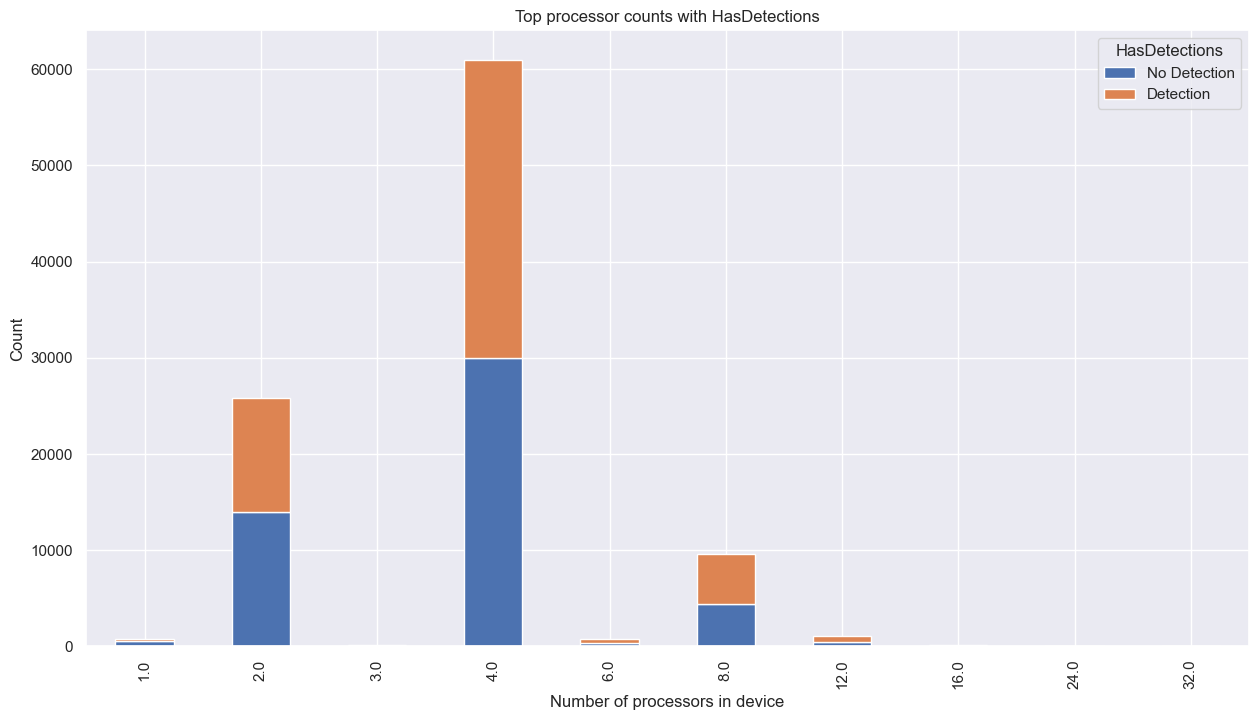

In [20]:
top_countries = train['Census_ProcessorCoreCount'].value_counts().head(10).index
subset_df = train[train['Census_ProcessorCoreCount'].isin(top_countries)]
plt.figure(figsize=(10, 6))
subset_df.groupby(['Census_ProcessorCoreCount', 'HasDetections']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Top processor counts with HasDetections')
plt.xlabel('Number of processors in device')
plt.ylabel('Count')
plt.legend(title='HasDetections', loc='upper right', labels=['No Detection', 'Detection'])
plt.show()


Most devices have 2,4 or 8 processors and detection rate is similar for all.

<Figure size 1000x600 with 0 Axes>

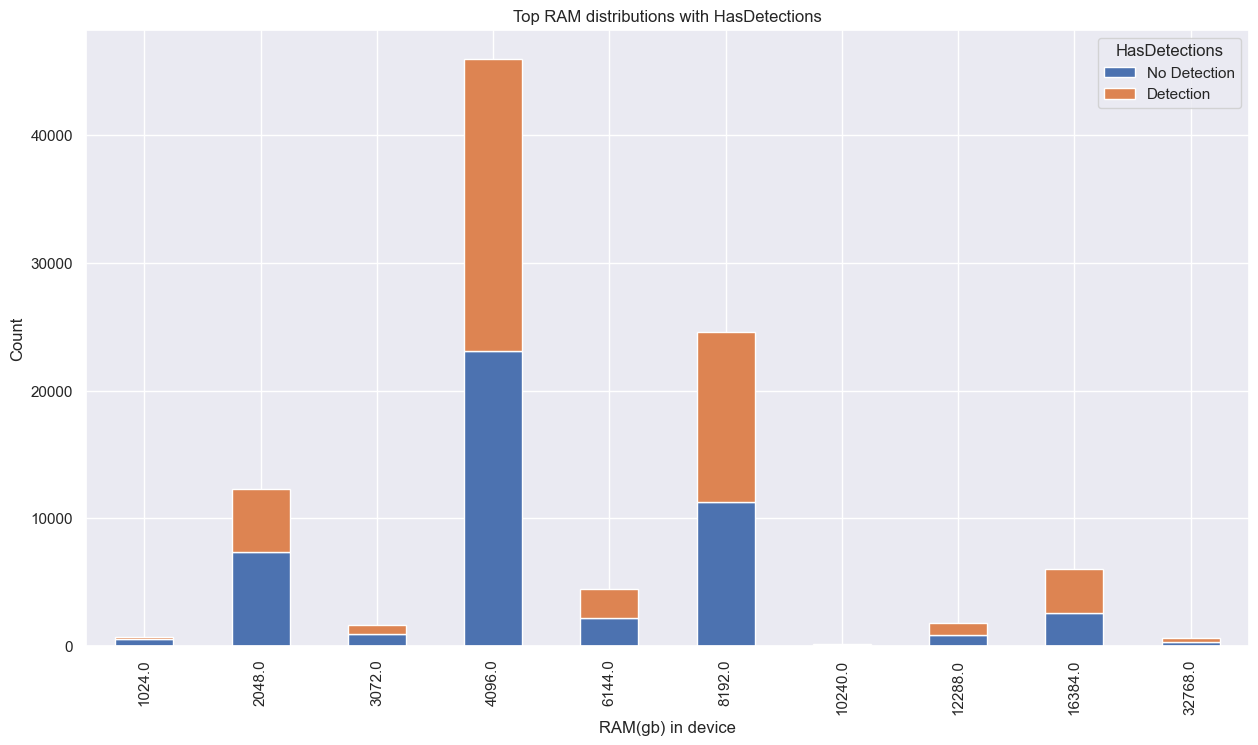

In [21]:
top_countries = train['Census_TotalPhysicalRAM'].value_counts().head(10).index
subset_df = train[train['Census_TotalPhysicalRAM'].isin(top_countries)]
plt.figure(figsize=(10, 6))
subset_df.groupby(['Census_TotalPhysicalRAM', 'HasDetections']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Top RAM distributions with HasDetections')
plt.xlabel('RAM(gb) in device')
plt.ylabel('Count')
plt.legend(title='HasDetections', loc='upper right', labels=['No Detection', 'Detection'])
plt.show()


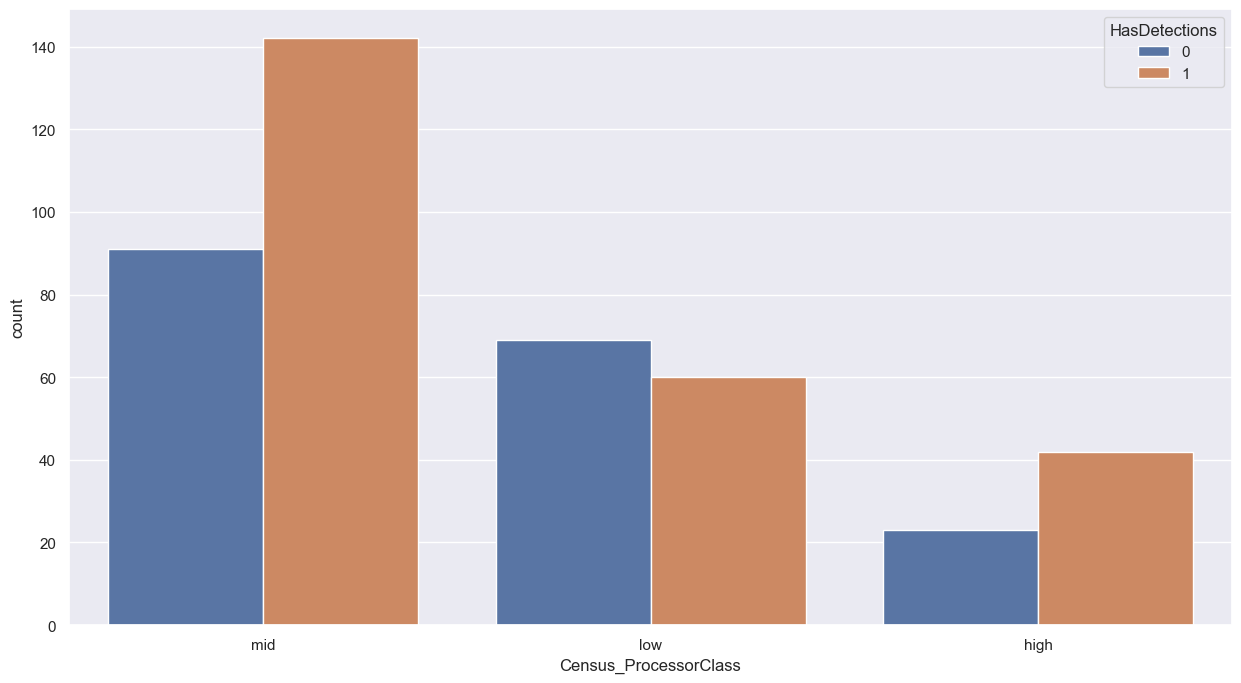

In [22]:
sns.countplot(x='Census_ProcessorClass', hue='HasDetections',data=train)
plt.show()

More logical processors seems to have higher infection rate.

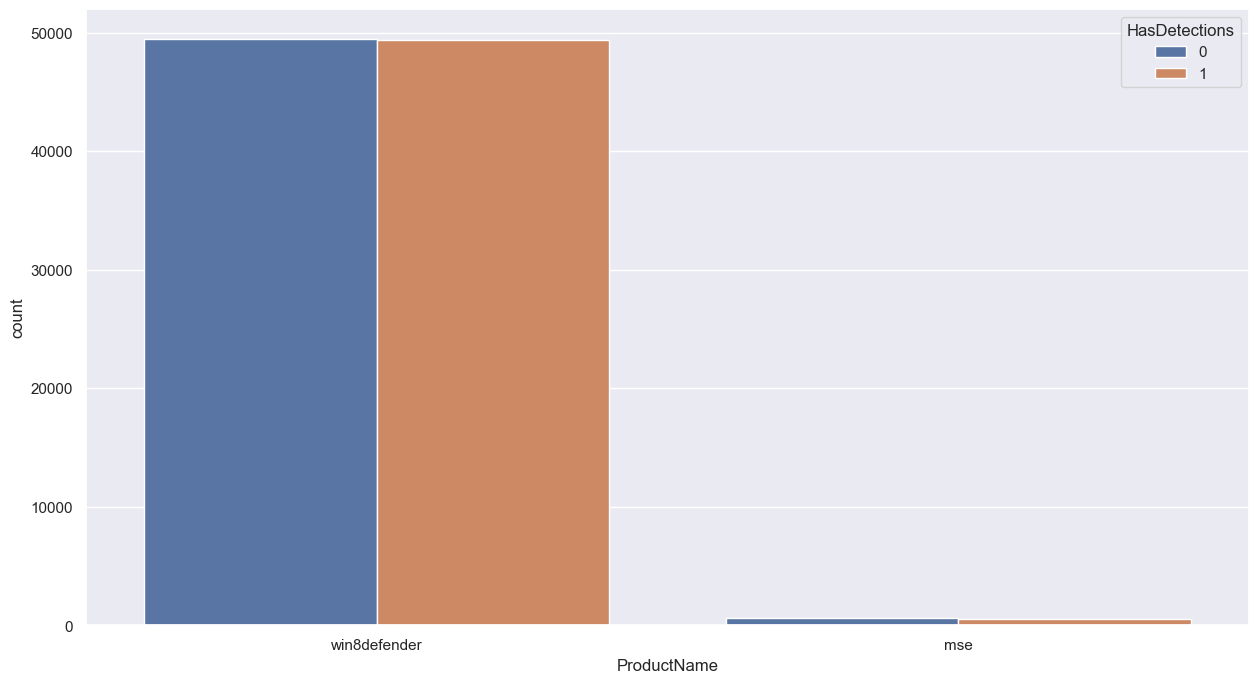

In [23]:
sns.countplot(x='ProductName', hue='HasDetections',data=train)
plt.show()

Nothing too interesting as detection rate is almost equal.

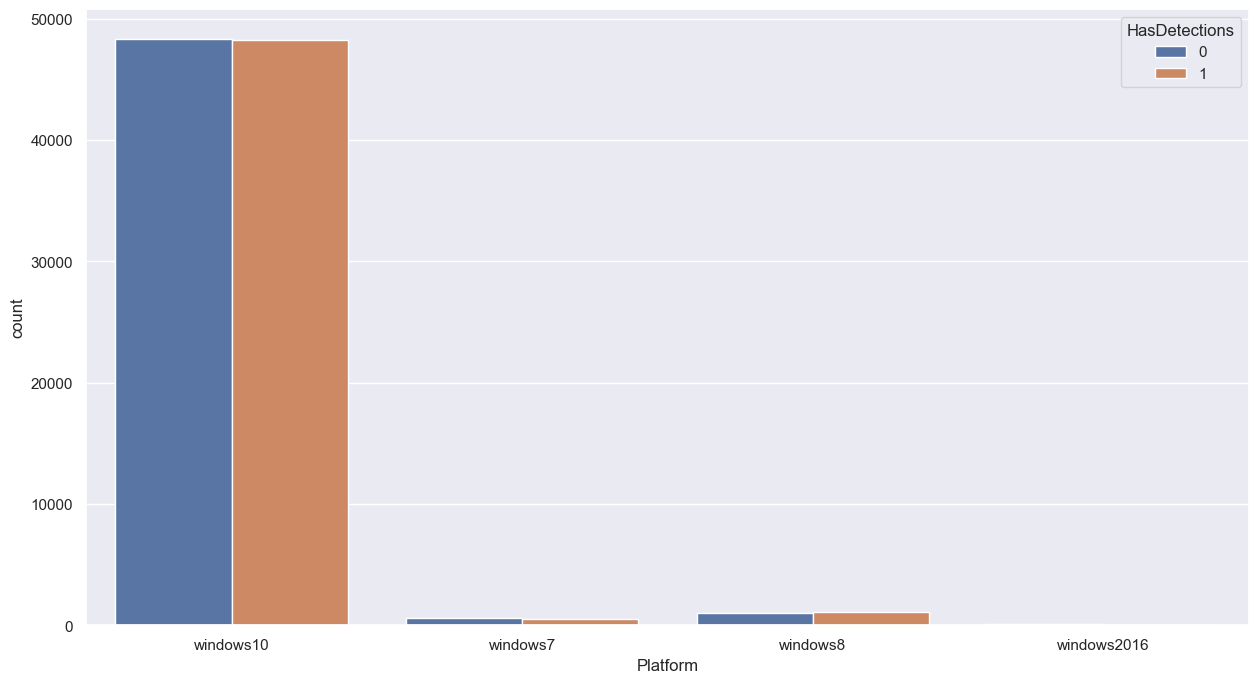

In [24]:
sns.countplot(x='Platform', hue='HasDetections',data=train)
plt.show()

Most devices from the data seems to be new as they features latest windows10 (at the time of data collection).

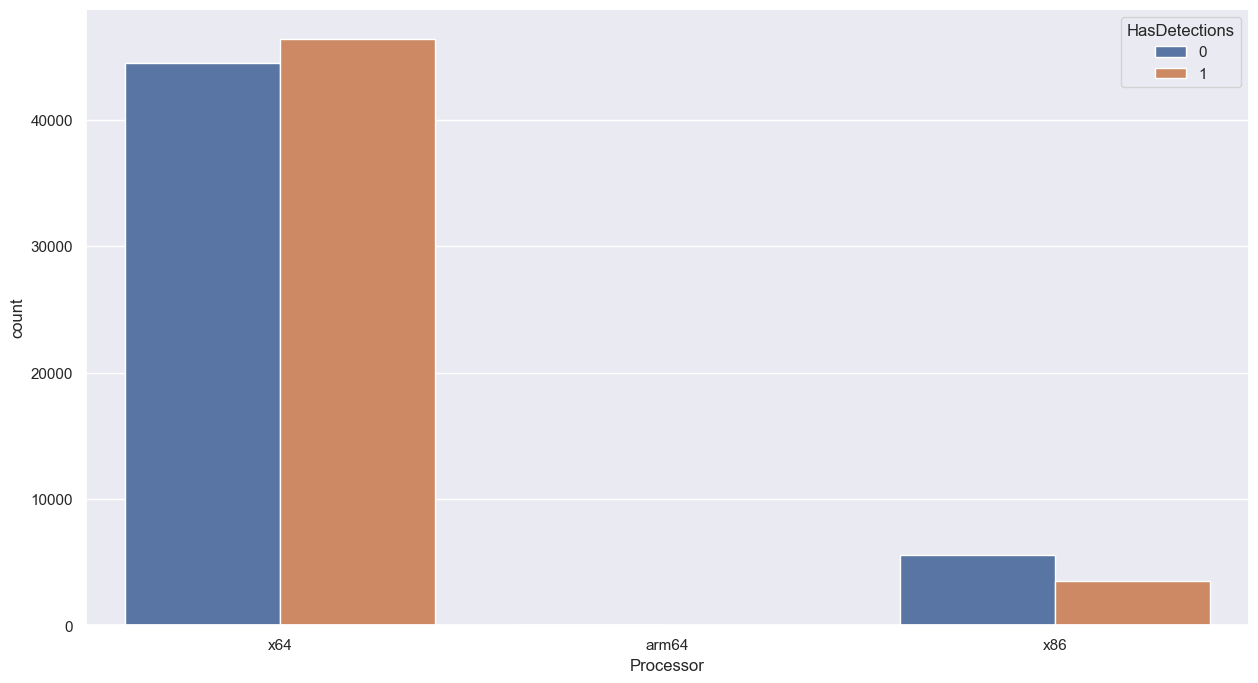

In [25]:
sns.countplot(x='Processor', hue='HasDetections',data=train)
plt.show()

Devices equipped with x64 are targeted more, but we don't have enough data to say anything about arm64 based devices.

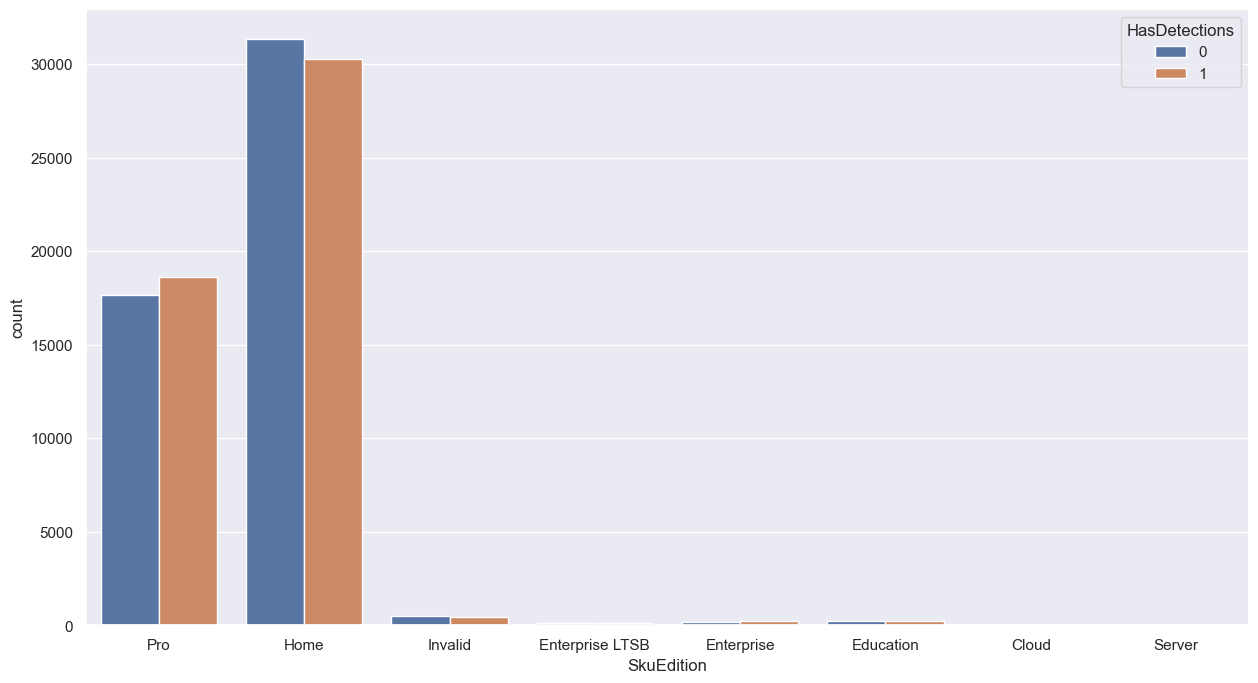

In [26]:
sns.countplot(x='SkuEdition', hue='HasDetections',data=train)
plt.show()

Pro devices are targeted more in comparision to home or enterprise based systems.

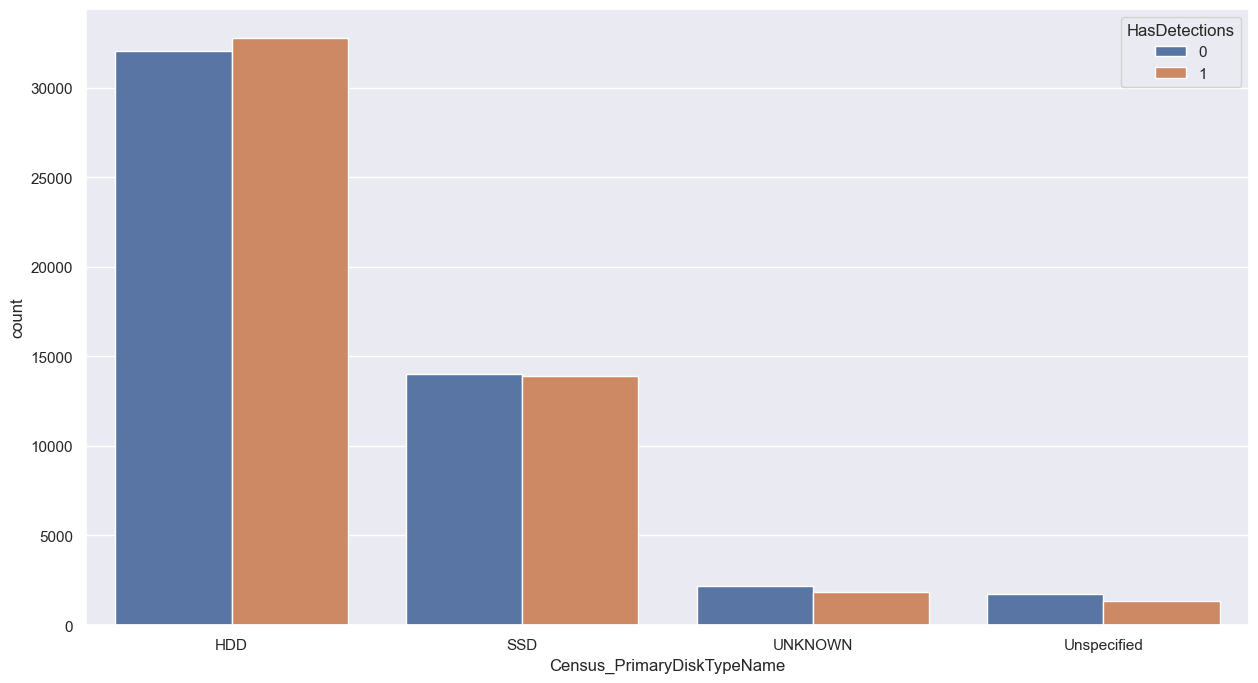

In [27]:
sns.countplot(x='Census_PrimaryDiskTypeName', hue='HasDetections',data=train)
plt.show()

Devices with HDD are targeted more which makes sense cause SDD devices are compartively new (at the time of the data) so they might have comparatively better security or advanced users.

In [28]:
pd.options.display.float_format = '{:,.4f}'.format
sk_df = pd.DataFrame([{'column': c, 'uniq': train[c].nunique(), 'skewness': train[c].value_counts(normalize=True).values[0] * 100} for c in train.columns])
sk_df = sk_df.sort_values('skewness', ascending=False)
sk_df

column    uniq  skewness
5                                              IsBeta       1  100.0000
28                                            PuaMode       1  100.0000
75                            Census_IsWIMBootEnabled       1  100.0000
68                         Census_IsFlightingInternal       1  100.0000
69                           Census_IsFlightsDisabled       1  100.0000
27                                    AutoSampleOptIn       2   99.9970
29                                              SMode       2   99.9649
71                              Census_ThresholdOptIn       2   99.9641
65                   Census_IsPortableOperatingSystem       2   99.9230
35                                Census_DeviceFamily       2   99.8610
33                                       UacLuaenable       3   99.3813
76                             Census_IsVirtualDevice       2   99.3358
1                                         ProductName       2   98.8800
12                                             HasTpm       2   98.7270
7                                    IsSxsPassiveMode       2   98.2370
32                                           Firewall       2   97.7326
11                                  AVProductsEnabled       5   97.4982
6                                    RtpStateBitfield       6   97.3163
20                                              OsVer      11   96.7510
18                                           Platform       4   96.6190
78                                Census_IsPenCapable       2   96.2850
26                                        IsProtected       2   94.4864
79            Census_IsAlwaysOnAlwaysConnectedCapable       2   94.2485
70                                  Census_FlightRing       7   93.6380
45                         Census_HasOpticalDiskDrive       2   92.4150
55                              Census_OSArchitecture       3   90.9360
19                                          Processor       3   90.9320
39             Census_ProcessorManufacturerIdentifier       4   88.2511
66                            Census_GenuineStateName       4   88.2190
77                              Census_IsTouchEnabled       2   87.4580
52                         Census_InternalBatteryType      22   78.3554
31                                        SmartScreen      11   75.1342
80                                       Wdft_IsGamer       2   71.8393
10                                AVProductsInstalled       5   70.1808
51                       Census_PowerPlatformRoleName       9   69.2690
15                             OrganizationIdentifier      37   68.0007
9                           AVProductStatesIdentifier    2069   65.7153
43                         Census_PrimaryDiskTypeName       4   64.9045
34                              Census_MDC2FormFactor      12   64.1180
22                                            OsSuite       7   62.1920
25                                         SkuEdition       8   61.6350
38                          Census_ProcessorCoreCount      17   61.2817
47                             Census_ChassisTypeName      30   58.8045
53              Census_InternalBatteryNumberOfCharges    1791   58.2057
3                                          AppVersion      80   57.9320
50    Census_InternalPrimaryDisplayResolutionVertical     197   55.9912
41                              Census_ProcessorClass       3   54.5667
67                           Census_ActivationChannel       6   52.8950
74                         Census_IsSecureBootEnabled       2   51.5010
49  Census_InternalPrimaryDisplayResolutionHorizontal     170   50.8339
82                                      HasDetections       2   50.0720
46                            Census_TotalPhysicalRAM     172   46.4024
56                                    Census_OSBranch      15   44.9990
57                               Census_OSBuildNumber      38   44.9950
64                   Census_OSWUAutoUpdateOptionsName       6   44.1270
21             

Need to drop these categorical columns which have 98% skewness.

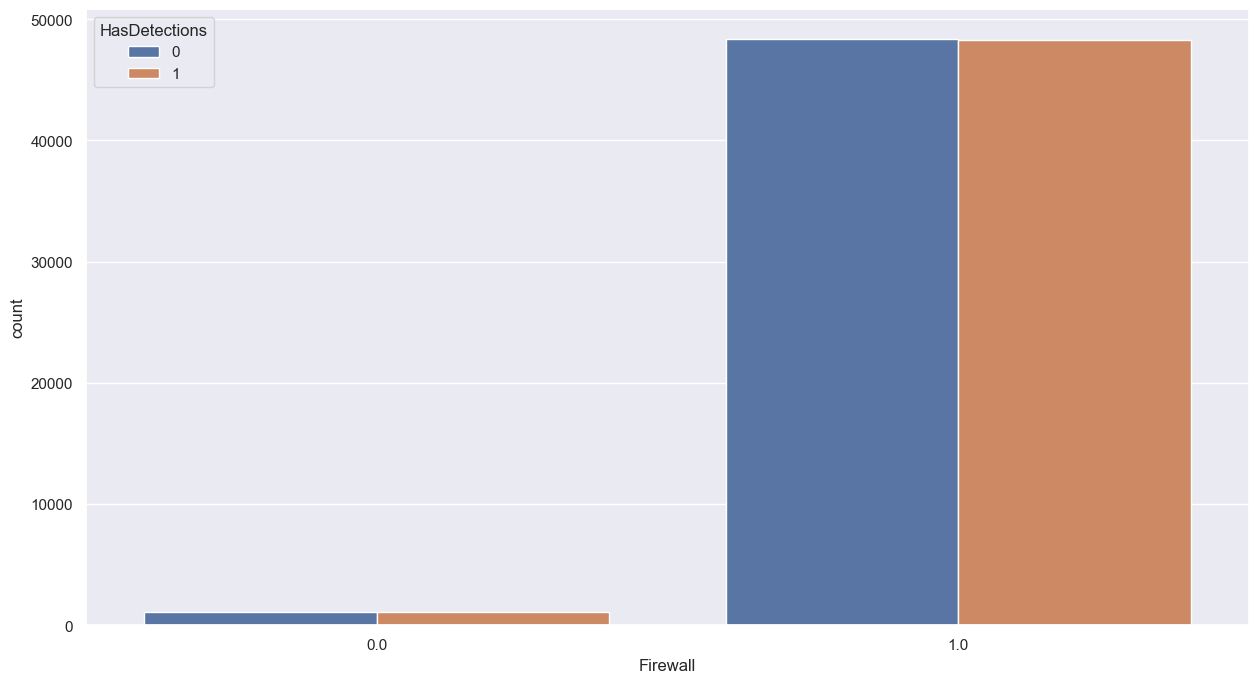

In [29]:
sns.countplot(x='Firewall', hue='HasDetections',data=train)
plt.show()

Interesting point, having Firewell doesn't matter much on if your device will be infected or not. Or maybe Firewall is not that effective.

In [30]:
droppable_features.extend(sk_df[sk_df.skewness > 99].column.tolist())
droppable_features

['PuaMode',
 'Census_ProcessorClass',
 'IsBeta',
 'PuaMode',
 'Census_IsWIMBootEnabled',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'AutoSampleOptIn',
 'SMode',
 'Census_ThresholdOptIn',
 'Census_IsPortableOperatingSystem',
 'Census_DeviceFamily',
 'UacLuaenable',
 'Census_IsVirtualDevice']

In [31]:
pd.options.display.max_rows = 99
train.Census_InternalBatteryType.value_counts()

Census_InternalBatteryType
lion    22535
li-i     2814
#        2028
lip       689
liio      371
li p       90
li         66
nimh       49
real       35
pbac       32
vbox       15
bq20       14
unkn        5
lipp        5
lgi0        3
lhp0        2
ithi        2
lio        1
batt        1
lipo        1
4cel        1
ram         1
Name: count, dtype: int64

In [32]:
trans_dict = {
    '˙˙˙': 'unknown', 'unkn': 'unknown', np.nan: 'unknown'
}
train.replace({'Census_InternalBatteryType': trans_dict}, inplace=True)

In [39]:
train = train.drop(columns=droppable_features)
test = test.drop(columns=droppable_features)

In [40]:
train.shape, test.shape

((100000, 70), (100000, 69))

### Conclusion

Upon comprehensive analysis, it can be deduced that no single feature is most dominant for this dataset. Multiple features combined together makes up if a device is vulnerable or not. One of the most interesting thing is User handling the device is most important and there's not much provided about them in the data. We know that even an older device which can be susceptible to malwares will be safe in the hands of an experienced user and a newer device with all the top notch security won't make itself secure in the hands of an amateur. Having multiple antiviruses won't make your system secure rather being precauticious at times would be much more helpful. Antiviruses, Windows Defenders, Firewall etcs are to assist user but there is no cure for Human Stupidity as said by famous hacker Kevin Mitnick.

This dataset still requires lot of Exploration and deep dive but that would be too time consuming for this short project.

Limitations:
This project doesn't apply any machine learning or deep learning based models.
No predictions were made to verify that the columns dropped were actually helpful in creasing the efficiency of the model or were they actually useless.
Model based Feature Importance would be interesting to see.
This project doesn't process the whole data because of the compute restrictions.